In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as transforms


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

from torchvision.utils import save_image

import matplotlib.pyplot as plt
import math

from utils import *

In [2]:
import os
from os import listdir

In [3]:
BASE_PATH_DATA = '../data/'

In [4]:
n_epochs = 10
batch_size = 64
lr = 1e-3
b1 = 0.9
b2 = 0.999
img_size = 28
channels = 1

log_interval = 100


z_size = 40

n = 28 * 28

# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")

In [6]:
print("Device")
print(device)

Device
cuda:0


In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/train',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        BASE_PATH_DATA + '/mnist/test', 
        train=False, 
        download = True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor()]
        )
    ),
    batch_size=batch_size, shuffle=True
)

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [34]:
class VAE_Gumbel_MNIST(nn.Module):
    def __init__(self, input_size, hidden_layer_size, z_size, k, t = 0.01):
        super(VAE_Gumbel_MNIST, self).__init__()
        
        self.k = k
        self.t = t
        
        # should probably add weight clipping to these gradients because you 
        # do not want the final output (initial logits) of this to be too big or too small
        # (values between -1 and 10 for first output seem fine)
        self.weight_creator = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, input_size),
            nn.LeakyReLU()
        )
        
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc21 = nn.Linear(hidden_layer_size, z_size)
        self.fc22 = nn.Linear(hidden_layer_size, z_size)
        self.fc3 = nn.Linear(z_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, input_size)

    def encode(self, x):
        w = self.weight_creator(x)
        subset_indices = sample_subset(w, self.k, self.t)
        x = x * subset_indices
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, img_size * img_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [101]:
def train(model, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function_per_autoencoder(data.view(-1, img_size * img_size), recon_batch, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(model, epoch, k):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function_per_autoencoder(data.view(-1, img_size * img_size), 
                                                       recon_batch, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '../data/gumbel_on_mnist/k_{}_reconstruction_'.format(k) + 
                           str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [102]:
k = 25

# any lower tends to produce sporadic results
t = 0.1

In [103]:
model = VAE_Gumbel_MNIST(784, 400, 20, k = k, t = t).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))

In [104]:
for epoch in range(1, n_epochs + 1):
        train(model = model, optimizer = optimizer, epoch= epoch)
        #with torch.no_grad():
        #    diag_model.diag.data[torch.abs(diag_model.diag) < 0.05] = 0
        test(model, epoch, k)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/gumbel_on_mnist/k_{}_sample_'.format(k) + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.272644
Train Epoch: 1 [6400/60000 (11%)]	Loss: 193.880295
Train Epoch: 1 [12800/60000 (21%)]	Loss: 199.551392
Train Epoch: 1 [19200/60000 (32%)]	Loss: 176.438690
Train Epoch: 1 [25600/60000 (43%)]	Loss: 168.237976
Train Epoch: 1 [32000/60000 (53%)]	Loss: 156.291382
Train Epoch: 1 [38400/60000 (64%)]	Loss: 146.051620
Train Epoch: 1 [44800/60000 (75%)]	Loss: 151.575043
Train Epoch: 1 [51200/60000 (85%)]	Loss: 139.460114
Train Epoch: 1 [57600/60000 (96%)]	Loss: 139.357834
====> Epoch: 1 Average loss: 169.4069
====> Test set loss: 137.7955
Train Epoch: 2 [0/60000 (0%)]	Loss: 144.043121
Train Epoch: 2 [6400/60000 (11%)]	Loss: 142.749023
Train Epoch: 2 [12800/60000 (21%)]	Loss: 144.876480
Train Epoch: 2 [19200/60000 (32%)]	Loss: 135.891174
Train Epoch: 2 [25600/60000 (43%)]	Loss: 135.233948
Train Epoch: 2 [32000/60000 (53%)]	Loss: 134.314194
Train Epoch: 2 [38400/60000 (64%)]	Loss: 145.619339
Train Epoch: 2 [44800/60000 (75%)]	Loss: 141.249359
Train Ep

In [105]:
for i, (data, _) in enumerate(test_loader):
    data = data.to(device)
    break

In [106]:
samp_index = 12

In [107]:
with torch.no_grad():
    w = model.weight_creator(data[samp_index, :].view(-1, img_size * img_size))
    subset_indices = sample_subset(w, k=k, t=t)

In [108]:
subset_indices.sort(descending = True)

torch.return_types.sort(
values=tensor([[4.4313e+00, 3.9491e+00, 2.0006e+00, 2.0000e+00, 1.8252e+00, 1.7829e+00,
         1.0109e+00, 1.0002e+00, 1.0001e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         9.9993e-01, 9.9977e-01, 6.1054e-01, 3.8945e-01, 1.0300e-05, 2.1860e-07,
         4.9880e-08, 9.4936e-09, 6.9199e-09, 5.4256e-09, 3.2302e-09, 3.0438e-09,
         2.8028e-09, 2.7042e-09, 2.5622e-09, 2.2953e-09, 2.2676e-09, 1.7808e-09,
         1.5922e-09, 1.4989e-09, 1.0562e-09, 1.0123e-09, 7.8829e-10, 7.8070e-10,
         5.6448e-10, 5.2509e-10, 2.4681e-10, 1.4397e-10, 9.9517e-11, 8.0048e-11,
         7.4768e-11, 5.3834e-11, 5.2832e-11, 4.6600e-11, 4.4521e-11, 4.4296e-11,
         3.2621e-11, 2.6647e-11, 2.4202e-11, 2.3765e-11, 2.3572e-11, 2.3056e-11,
         2.1425e-11, 1.5054e-11, 1.4171e-11, 1.3824e-11, 1.3174e-11, 1.0539e-11,
         1.0063e-11, 9.0390e-12, 7.8765e-12, 5.9020e-12, 5.3655e-12, 4.9208e-12,
         4.0843e-12, 3.6180e-12, 3.5852e-12, 3.4444e-12, 3.3856e-12, 2.9518e-

In [109]:
thres = subset_indices[:,subset_indices.argsort(descending=True)[:,:k][:, -1]]

In [110]:
thres

tensor([[2.8028e-09]], device='cuda:0')

In [111]:
subset_indices.argsort(descending=True)

tensor([[151, 525, 688, 461, 351, 128, 607, 626, 458, 623, 189, 267, 347, 373,
         631, 369, 492, 566, 379, 518, 406, 655, 657, 660, 276, 292, 301, 605,
         595, 550, 686, 156, 302, 551, 683, 371, 401, 402, 185, 264, 323, 160,
         182, 437, 407, 627, 459, 575, 462, 598, 370, 125, 467, 434, 653, 548,
         540, 210, 230, 316, 438, 569, 355, 404, 662, 293, 206, 684, 269, 294,
         130, 352, 491, 124, 266, 382, 296, 549, 353, 439, 154, 318, 346, 356,
         433, 413, 567, 516, 241, 411, 148, 176, 350, 259, 523, 242, 409, 408,
         317, 398, 207, 177, 538, 344, 410, 465, 202, 580, 238, 578, 215, 427,
         574, 233, 372, 512, 386, 295, 123, 357, 385, 297, 380, 275, 211, 217,
         326, 208, 349, 543, 289, 652, 126, 263, 603, 570, 573, 602, 262, 522,
         400, 456, 246, 405, 330, 315, 383, 325, 412, 659, 546, 218, 299, 204,
         328, 636, 716, 494, 509, 129, 483, 234,  72, 377, 545, 270, 327, 300,
         714, 426, 517, 544, 633, 443, 187, 431, 127

In [112]:
print("Are some things are printing above 1")
subset_indices[subset_indices > 1].shape

Are some things are printing above 1


torch.Size([9])

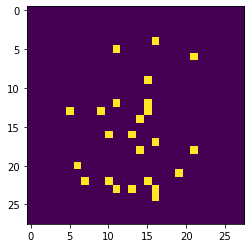

In [113]:
plt.imshow((subset_indices.reshape((28, 28)) > thres).clone().detach().cpu().numpy())

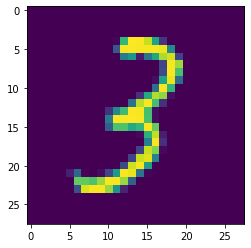

In [114]:
plt.imshow(data[samp_index, :].view(28, 28).clone().detach().cpu().numpy())

# this needs to be rewritten to use the threshold stuff above

k_all = [10, 25, 50, 250]

for k in k_all:
    model = VAE_Gumbel_MNIST(784, 400, 20, k = k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (b1,b2))
    for epoch in range(1, n_epochs + 1):
        train(model, optimizer, epoch)
        #with torch.no_grad():
        #    diag_model.diag.data[torch.abs(diag_model.diag) < 0.05] = 0
        test(model, epoch, k)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../data/gumbel_on_mnist/k_{}_sample_'.format(k) + str(epoch) + '.png')
    with torch.no_grad():
        w = model.weight_creator(data[0, :].view(-1, 784))
        subset_indices = sample_subset(w, k=k, t=0.1).cpu()
    plt.imshow(subset_indices.reshape((28, 28)) > 0.01)
    plt.imsave('../data/gumbel_on_mnist/k_{}_example_featureselected.png'.format(k), 
               subset_indices.reshape((28, 28)) > 0.01)